In [ ]:
conda install -c anaconda tensorflow-gpu

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: / 

In [ ]:
conda install -c anaconda cudatoolkit

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices()

In [ ]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

In [15]:
# Import Libraries
from numpy import expand_dims, zeros, ones, vstack, add
from numpy.random import randn, randint, normal
from matplotlib import pyplot
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization, ReLU

In [16]:
## 2D Scan The World busts dataset: 
dataset_name = "scan-the-world-busts-images"
dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/scan-the-world-busts-images/"

# Model input dimensions
img_rows = 64
img_cols = 64
channels = 3

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

# Number of data points used in each training loop
batch_size = 128

# Number of training epochs
num_epochs = 150

# Learning rate for training
learning_rate = 0.0002

# Hyperparameter for Adam optimizers
beta_1 = 0.5

In [17]:
# Load dataset
dataset = image_dataset_from_directory(
    dataroot, label_mode=None, shuffle=True, seed=999, image_size=(img_rows, img_cols), batch_size=batch_size
)
dataset = dataset.map(lambda x: x / 255.0)

Found 1291 files belonging to 1 classes.


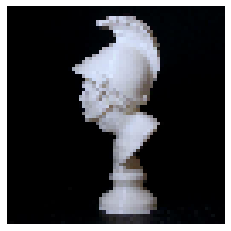

In [18]:
# Visualise dataset
for x in dataset:
    pyplot.axis("off")
    pyplot.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [29]:
# Discriminator model
def define_discriminator(in_shape=img_shape):
    model = Sequential([
          Input(shape=(64, 64, 3)),
          Conv2D(64, kernel_size=4, strides=2, padding="same"),
          LeakyReLU(alpha=0.2),
          Conv2D(128, kernel_size=4, strides=2, padding="same"),
          BatchNormalization(),
          LeakyReLU(alpha=0.2),
          Conv2D(128, kernel_size=4, strides=2, padding="same"),
          BatchNormalization(),
          LeakyReLU(alpha=0.2),
          Flatten(),
          Dropout(0.2),
          Dense(1, activation="sigmoid"),
      ],
      name="discriminator",
  )
    return model

In [30]:
# # Discriminator summary
# discriminator = define_discriminator((64,64,3))

# discriminator.summary()

In [31]:
# Generator model
def define_generator(z_dim):
    model = Sequential([
         Input(shape=(z_dim,)),
         Dense(8 * 8 * 128),
         Reshape((8, 8, 128)),
         Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
         BatchNormalization(),
         LeakyReLU(alpha=0.2),
         Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
         BatchNormalization(),
         LeakyReLU(alpha=0.2),
         Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
         BatchNormalization(),
         LeakyReLU(alpha=0.2),
         Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
    return model

In [22]:
# Generator summary
# generator = define_generator(z_dim)

# generator.summary()

In [32]:
# GAN model
def define_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)

    return model

In [36]:
# Build and compile the Discriminator
discriminator = define_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(learning_rate=learning_rate, beta_1=beta_1),
                      metrics=['accuracy'])
discriminator.summary()

# Build the Generator
generator = define_generator(z_dim)
generator.summary()

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = define_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate, beta_1=beta_1))

# GAN summary
# gan.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 128)       131200    
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 128)         262272    
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 8, 128)       

In [37]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Generate images from random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0])
            axs[i, j].axis('off')
            cnt += 1

In [ ]:
# Training loop 

# List of training values
img_list = []
g_losses = []
d_losses = []
d_accuracies = []

# Labels for images
y_real = ones((batch_size, 1))
y_fake = zeros((batch_size, 1))

iterations = 0

for epoch in range(num_epochs):
    for i, imgs in enumerate(dataset):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Generate a batch of fake images
        z = normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)

        # Train the discriminaor on the generated images
        d_loss_real = discriminator.train_on_batch(imgs, y_real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, y_fake)

        d_loss, d_accuracy = 0.5 * add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)


        # Train the generator via the gan model - note inverted labels
        g_loss = gan.train_on_batch(z, y_real)

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_D_fake: %.4f\tLoss_D_real: %.4f\tLoss_G: %.4f\tD_acc: %.4f'
                  % (epoch, num_of_epochs, i, len(dataset), d_loss, d_loss_fake, d_loss_real, g_loss, d_accuracy))

        # Save losses for plotting later
        g_losses.append(g_loss)
        d_losses.append(d_loss)
        d_fake_losses.append(d_loss_fake)
        d_real_losses.append(d_loss_real)
        d_accuracies.append(d_accuracy)

        # Check how the generator is doing by predicting G's output
        if (iterations % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            sample_images(generator)

        iterations += 1

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.plot(D_fake_losses,label="D_fake")
plt.plot(D_real_losses,label="D_real")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(path,"generator_discriminator_losses.png"))

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Discriminator Accuracy During Training")
plt.plot(D_x_acc,label="D_acc")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(os.path.join(path,"discriminator_accuracy.png"))